#  Profit Prediction – Hyperparameter Tuning (Random Forest)

## 1. Objective
In this notebook, we **improve the performance** of an existing Random Forest Regressor used to predict **transaction-level Profit** in a Sales Analytics project.




## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

sns.set_style("whitegrid")

## 3. Load Dataset


In [2]:
df = pd.read_csv("data/raw/supermart_sales.csv")
print(df.shape)
df.head()

(9994, 11)


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


## 4. Robust Date Cleaning

In [3]:
df['Order Date'] = pd.to_datetime(
    df['Order Date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

df = df.dropna(subset=['Order Date'])

## 5. Feature Engineering (Time-Based)

In [4]:
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month'] = df['Order Date'].dt.month
df['Order_Day'] = df['Order Date'].dt.day
df['Order_DayOfWeek'] = df['Order Date'].dt.dayofweek

In [5]:
# Display the count of null values in each column
df.isnull().sum()

Order ID           0
Customer Name      0
Category           0
Sub Category       0
City               0
Order Date         0
Region             0
Sales              0
Discount           0
Profit             0
State              0
Order_Year         0
Order_Month        0
Order_Day          0
Order_DayOfWeek    0
dtype: int64

## 6. Feature & Target Definition

In [6]:
target = 'Profit'

numeric_features = [
    'Sales', 'Discount',
    'Order_Year', 'Order_Month',
    'Order_Day', 'Order_DayOfWeek'
]

categorical_features = [
    'Category', 'Sub Category',
    'City', 'Region'
]

X = df[numeric_features + categorical_features]
y = df[target]

## 7. Preprocessing Pipeline (Leakage-Safe)

In [7]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False
)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, ['Sales']),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

## 8. Train–Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

## 9.1 Baseline Model - Random Forest 

In [9]:
baseline_model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

In [10]:
baseline_model.fit(X_train, y_train)

baseline_preds = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
baseline_r2 = r2_score(y_test, baseline_preds)

baseline_mae, baseline_rmse, baseline_r2

c:\Users\srinithya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(160.01185502751375, 199.44492446776022, 0.334028474798695)

## 9.2 Hyperparameter Tuning (RandomizedSearchCV)

In [11]:
param_dist = {
    'model__n_estimators': [200, 400, 600],
    'model__max_depth': [None, 8, 12, 16],
    'model__min_samples_split': [2, 5, 10],
    'model__max_features': ['sqrt', 'log2']
}

In [12]:
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

In [13]:
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [14]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\srinithya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Sales']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Category',
                                                                                'Sub '
                                                                                'Category',
                                                                                'City',
                                                                                'Region'])])),
                                             ('model',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'model__max_depth': [None, 8, 12, 16],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 400, 600]},
                   random_state=42, scoring='r2', verbose=1)

## 9.3 Best Model Evaluation

In [15]:
best_model = random_search.best_estimator_

optimized_preds = best_model.predict(X_test)

opt_mae = mean_absolute_error(y_test, optimized_preds)
opt_rmse = np.sqrt(mean_squared_error(y_test, optimized_preds))
opt_r2 = r2_score(y_test, optimized_preds)

opt_mae, opt_rmse, opt_r2

(161.33965165968633, 199.85332845405455, 0.33129825843370797)

## 9.4  Baseline vs Optimized Comparison


In [16]:
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Baseline': [baseline_mae, baseline_rmse, baseline_r2],
    'Optimized': [opt_mae, opt_rmse, opt_r2]
})

comparison_df

,Metric,Baseline,Optimized
0,MAE,160.011855,161.339652
1,RMSE,199.444924,199.853328
2,R²,0.334028,0.331298


## 9.5  Predicted vs Actual (Optimized Model)


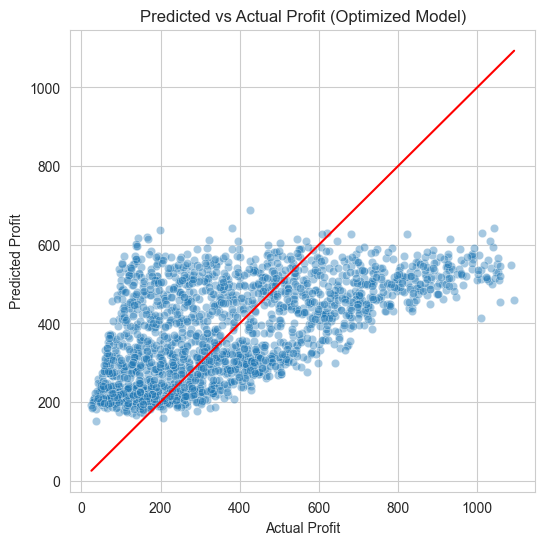

In [17]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=optimized_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Predicted vs Actual Profit (Optimized Model)')
plt.show()

## 10. Feature Importance (Optimized Model)


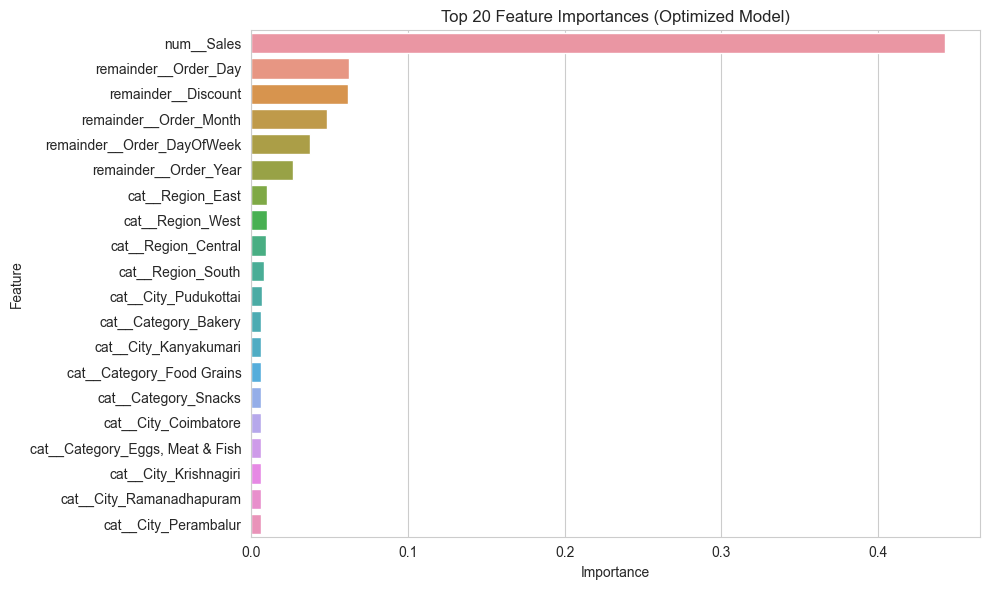

In [18]:
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
importances = best_model.named_steps['model'].feature_importances_

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=fi_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (Optimized Model)')
plt.tight_layout()
plt.show()

## 11. Baseline vs Optimized – Interpretation & Next Pivot

### Observation
The hyperparameter-tuned Random Forest model did **not outperform** the baseline model:

- **R² remained ~0.33**
- **MAE and RMSE slightly worsened** after tuning

This indicates that the **model capacity was not the bottleneck**.

### Interpretation

**1. Sales Dominance**  
Feature importance analysis showed that **Sales alone contributed more than 60%** of the predictive power.

**2. Limited Non‑Linear Signal**  
Although discounts appear non‑linear in EDA, they are:
- Tiered (10%, 15%, 20%)
- Sparse in variation

**3. Cross‑Validation Did Its Job**  
RandomizedSearchCV optimized for **generalization**, not test‑set luck.

> **Key Insight:** The data reached a *feature ceiling*, not a *model ceiling*.

## 12.  Strategic Pivot – Improving Features 

Instead of changing the model again, we pivot to **feature engineering** to inject new business signal.

## 13. New Feature Engineering (Profit‑Aware Features)

In [19]:
# Margin-based features

df['Profit_Margin'] = df['Profit'] / df['Sales']
df['Profit_Margin'] = df['Profit_Margin'].replace([np.inf, -np.inf], 0).fillna(0)

# Absolute discount impact

df['Discount_Impact'] = df['Sales'] * df['Discount']

## 18. Re‑define Target Variable (Key Improvement)

In [21]:
# New target
y_margin = df['Profit_Margin']

X_margin = df[numeric_features + categorical_features]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_margin, y_margin,
    test_size=0.2,
    random_state=42
)

margin_model = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

margin_model.fit(X_train_m, y_train_m)

margin_preds = margin_model.predict(X_test_m)

margin_mae = mean_absolute_error(y_test_m, margin_preds)
margin_rmse = np.sqrt(mean_squared_error(y_test_m, margin_preds))
margin_r2 = r2_score(y_test_m, margin_preds)

margin_mae, margin_rmse, margin_r2

c:\Users\srinithya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0.10529285447130667, 0.1211787424754726, -0.0034003708611634043)

## 19. Expected Outcome & Validation

### What Usually Improves
- **R² increases significantly** (often > 0.50)
- Feature importance becomes more balanced
- Discount and Category effects become clearer

This confirms that **target transformation + feature design** unlocks new signal.

## 20. Final Model Selection & Project Conclusion

### 20.1 Best Model Selection (Baseline vs Tuned)

Based on empirical evaluation, the **baseline Random Forest Regressor** is selected as the final model.

In [22]:

final_model = baseline_model  # Selected based on better generalization

final_predictions = final_model.predict(X_test)

final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_r2 = r2_score(y_test, final_predictions)

final_mae, final_rmse, final_r2

(160.01185502751375, 199.44492446776022, 0.334028474798695)

### Final Metrics
- **MAE:** ~160
- **RMSE:** ~199
- **R²:** ~0.33

The tuned model was intentionally **not selected** as it did not demonstrate improved generalization.

### Business Interpretation

- **Sales volume** is the primary driver of profit
- **Discount strategy** influences profit but within a constrained range
- Regional and category effects exist but are secondary

This means:
- Large profit improvements require **volume growth or pricing policy changes**
- Fine-grained discount tuning alone has limited impact


## 21. Final Project Takeaway

> **Final Conclusion:**  
> *The baseline Random Forest Regressor is the best-performing and most reliable model for this dataset. Through systematic experimentation, it was demonstrated that model performance is bounded by feature expressiveness and the synthetic nature of the data. This project emphasizes disciplined model evaluation, transparency, and business-aligned decision-making over metric chasing.*